In [1]:
import os
import sys
import json
sys.path.insert(0, os.path.abspath('../'))
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from keras import layers

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
SHIFT_WIDTH = 40
REG_JUMP = 2

In [3]:
SHUFFLE = True
MAX_EPOCHS = 10000
BATCH_SIZE = 1024
NB_FEATURES = 2

In [4]:
loaded = np.load(f'./training_data/training_set_{SHIFT_WIDTH}_{REG_JUMP}.npz')
input_signals = loaded['input_signals']
input_labels = loaded['input_labels']
input_features = loaded['input_features']
input_reg_signals = loaded['input_reg_signals']
input_reg_labels = loaded['input_reg_labels']
count_0 = loaded['count_0']
count_1 = loaded['count_1']

total = count_0 + count_1
weight_for_0 = (1 / count_0) * (total / 2.0)
weight_for_1 = (1 / count_1) * (total / 2.0)
class_weight = {0: weight_for_0, 1:weight_for_1}

print(input_signals.shape, input_labels.shape)
print(input_reg_signals.shape, input_reg_labels.shape)
print(class_weight, count_0, count_1)
print(input_features.shape)

(160624, 45, 80) (160624,)
(377507, 45, 80) (377507,)
{0: 0.7149330128633107, 1: 1.663153099049473} 112335 48289
(160624, 45)


In [5]:
input_signals = input_signals[:, :, :input_signals.shape[-1]//2]
input_reg_signals = input_reg_signals[:, :, :input_reg_signals.shape[-1]//2]

#input_signals = np.swapaxes(input_signals, 1, 2)
#input_reg_signals = np.swapaxes(input_reg_signals, 1, 2)

INPUT_CLS_SHAPE = [-1, input_signals.shape[1], input_signals.shape[2], 1]
INPUT_REG_SHAPE = [-1, input_reg_signals.shape[1], input_reg_signals.shape[2], 1]

In [6]:
def shuffle(data, *args):
    shuffle_index = np.arange(data.shape[0])
    np.random.shuffle(shuffle_index)
    args = list(args)
    for i, arg in enumerate(args):
        args[i] = arg[shuffle_index]
    return data[shuffle_index], *args

In [7]:
input_features = input_features.reshape(-1, input_signals.shape[1], 1, 1)
input_signals = input_signals.reshape(INPUT_CLS_SHAPE)
input_labels = input_labels.reshape(-1, 1)
input_reg_signals = input_reg_signals.reshape(INPUT_REG_SHAPE)
input_reg_labels = input_reg_labels.reshape(-1, 1)
input_signals, input_labels, input_features = shuffle(input_signals, input_labels, input_features)
input_reg_signals, input_reg_labels = shuffle(input_reg_signals, input_reg_labels)

In [8]:
train_input = []
train_label = []
train_feature = []
val_input = []
val_label = []
val_feature = []
cur_count_0 = 0
cur_count_1 = 0
for i in range(len(input_labels)):
    if input_labels[i] == 0:
        cur_count_0 += 1
        if cur_count_0 < int(count_0 * 0.8):
            train_input.append(input_signals[i])
            train_label.append(input_labels[i])
            train_feature.append(input_features[i])
        else:
            val_input.append(input_signals[i])
            val_label.append(input_labels[i])
            val_feature.append(input_features[i])
    else:
        cur_count_1 += 1
        if cur_count_1 < int(count_1 * 0.8):
            train_input.append(input_signals[i])
            train_label.append(input_labels[i])
            train_feature.append(input_features[i])
        else:
            val_input.append(input_signals[i])
            val_label.append(input_labels[i])
            val_feature.append(input_features[i])
            
train_input = np.array(train_input)
train_label = np.array(train_label)
train_feature = np.array(train_feature)
val_input = np.array(val_input)
val_label = np.array(val_label)
val_feature = np.array(val_feature)

train_reg_input = input_reg_signals[:int(input_reg_signals.shape[0] * 0.8)]
train_reg_label = input_reg_labels[:int(input_reg_labels.shape[0] * 0.8)]
val_reg_input = input_reg_signals[int(input_reg_signals.shape[0] * 0.8):]
val_reg_label = input_reg_labels[int(input_reg_labels.shape[0] * 0.8):]

In [9]:
train_input, train_label, train_feature = shuffle(train_input, train_label, train_feature)
val_input, val_label, val_feature = shuffle(val_input, val_label, val_feature)
train_reg_input, train_reg_label = shuffle(train_reg_input, train_reg_label)
val_reg_input, val_reg_label = shuffle(val_reg_input, val_reg_label)

In [10]:
print(f'train_cls_shape:{train_input.shape}\n',
      f'train_feat_shape:{train_feature.shape}\n'
      f'val_cls_shape:{val_input.shape}\n',
      f'val_feat_shape:{val_feature.shape}\n'
      f'train_reg_shape:{train_reg_input.shape}\n',
      f'val_reg_shape:{val_reg_input.shape}\n',
     )

train_cls_shape:(128497, 45, 40, 1)
 train_feat_shape:(128497, 45, 1, 1)
val_cls_shape:(32127, 45, 40, 1)
 val_feat_shape:(32127, 45, 1, 1)
train_reg_shape:(302005, 45, 40, 1)
 val_reg_shape:(75502, 45, 40, 1)



In [12]:
signal_input = keras.Input(shape=(None, None, 1), name="signals")
feature_input = keras.Input(shape=(None, 1, 1), name="features")

x1 = layers.ConvLSTM1D(filters=16, kernel_size=2, strides=1, padding='same', dropout=0.1)(signal_input)
x1 = layers.ReLU()(x1)
x1 = layers.Bidirectional(layers.LSTM(16))(x1)
x1 = layers.ReLU()(x1)
x1 = layers.Flatten()(x1)

#x2 = layers.ConvLSTM1D(filters=16, kernel_size=2, strides=1, padding='same')(feature_input)
x2 = layers.Resizing(height=20, width=1)(feature_input)
x2 = layers.Flatten()(x2)
cls_concat = layers.concatenate([x1, x2])
cls_dense = layers.Dense(units=2, activation='relu')(cls_concat)
cls_last_layer = layers.Dense(units=1, activation='sigmoid')(cls_dense)

cls_model = keras.Model(
    inputs=[signal_input, feature_input],
    outputs=[cls_last_layer],
    name='anomalous_detection'
)

2024-05-15 14:45:31.098066: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-15 14:45:31.098271: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-15 14:45:31.098285: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-15 14:45:31.098494: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-15 14:45:31.098868: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
cls_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='acc'),
                           tf.keras.metrics.FalsePositives(name='FP'),
                           tf.keras.metrics.FalseNegatives(name='FN'),
                           tf.keras.metrics.TruePositives(name='TP'),
                           tf.keras.metrics.TrueNegatives(name='TN')]
                 )
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=100,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True,
                                                  start_from_epoch=15
                                                 )

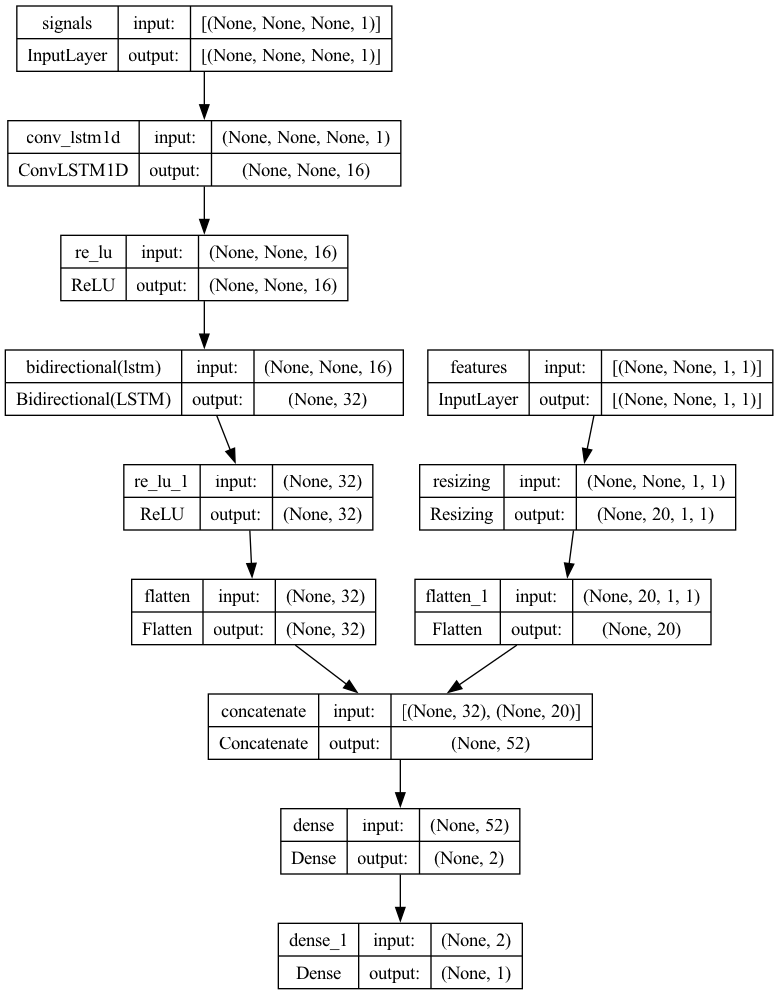

In [14]:
keras.utils.plot_model(cls_model, "cls_model.png", show_shapes=True)

In [15]:
cls_model.summary()

Model: "anomalous_detection"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 signals (InputLayer)        [(None, None, None, 1)]      0         []                            
                                                                                                  
 conv_lstm1d (ConvLSTM1D)    (None, None, 16)             2240      ['signals[0][0]']             
                                                                                                  
 re_lu (ReLU)                (None, None, 16)             0         ['conv_lstm1d[0][0]']         
                                                                                                  
 bidirectional (Bidirection  (None, 32)                   4224      ['re_lu[0][0]']               
 al)                                                                            

In [16]:
cls_history = cls_model.fit(x=[train_input, train_feature],
                        y=train_label,
                        validation_data=([val_input, val_feature], val_label),
                        batch_size=BATCH_SIZE,
                        epochs=MAX_EPOCHS,
                        shuffle=True,
                        callbacks=[early_stopping],
                        class_weight=class_weight,
                        verbose=2
                       )
cls_model.save(f'./models/cls_model_{SHIFT_WIDTH}_{REG_JUMP}.keras')
history_dict = cls_history.history
json.dump(history_dict, open(f'./models/cls_history_{SHIFT_WIDTH}_{REG_JUMP}.json', 'w'))

Epoch 1/10000


2024-05-15 14:45:58.094905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-15 14:45:58.328498: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.

KeyboardInterrupt



# Regression

In [17]:
reg_input = keras.Input(shape=(None, None, 1), name="reg_signals")

x = layers.ConvLSTM1D(filters=16, kernel_size=2, strides=1, padding='same', dropout=0.1)(reg_input)
x = layers.ReLU()(x)
x = layers.Bidirectional(layers.LSTM(16))(x)
x = layers.ReLU()(x)
x = layers.Flatten()(x)
reg_dense = layers.Dense(units=2, activation='relu')(x)
reg_last_layer = layers.Dense(units=1)(reg_dense)

reg_model = keras.Model(
    inputs=[reg_input],
    outputs=[reg_last_layer],
    name='anomalous_regression'
)

In [18]:
reg_model.compile(loss=tf.keras.losses.MeanSquaredError(name='mean_squared_error'),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=[tf.keras.metrics.MeanAbsoluteError(name='MAE'),
                          ]
                 )
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=50,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True,
                                                  start_from_epoch=15
                                                 )

In [19]:
reg_history = reg_model.fit(x=train_reg_input,
                        y=train_reg_label,
                        validation_data=(val_reg_input, val_reg_label),
                        batch_size=BATCH_SIZE,
                        epochs=MAX_EPOCHS,
                        shuffle=True,
                        callbacks=[early_stopping],
                        verbose=2
                       )
reg_model.save(f'./models/reg_model_{SHIFT_WIDTH}_{REG_JUMP}.keras')
history_dict = reg_history.history
json.dump(history_dict, open(f'./models/reg_history_{SHIFT_WIDTH}_{REG_JUMP}.json', 'w'))

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x151703c70>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 

KeyboardInterrupt

